In [1]:
import torch
from torch.backends import cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import *
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from datetime import datetime as dt
from datetime import timedelta

from config.config_cloud import Config_cloud

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True
cudnn.deterministic = True

In [2]:
Cfg = Config_cloud()

In [3]:
data = pd.read_pickle('data/data_test.pkl')
cloud_clip = np.load("data/test_cloud_clip.npy")
cloud_all = np.stack(list(data['cloud'].values()))
data_met = pd.read_pickle('data/data_test_met.pkl')

In [4]:
root_path = "/mnt/nasbi/no-backups/datasets/video_datasets/cloud_video/"

In [5]:
import segmentation_models_pytorch as smp
in_channels = 46
cloud2cloud = smp.PSPNet(encoder_name='vgg19_bn', classes=4)
cloud2cloud.encoder.features[0] = torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cloud2cloud.load_state_dict(torch.load('save_model/25.pth'))
cloud2cloud = cloud2cloud.cuda()
cloud2cloud.eval()

PSPNet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(46, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [6]:
submit = []
for i in range(len(cloud_clip)):
#for i in range(1,10):
    cloud_list = cloud_clip[i] 
    end_id =  str(cloud_list[-1])
    year, month, day, hour = end_id[:4], end_id[4:6], end_id[6:8], end_id[8:10]
    
    x = []
    for cloud_id in cloud_list:
        cloud_x = data['cloud'][str(cloud_id)]/255
        x.append(cloud_x)
    x = np.stack(x)

    end_id =  str(cloud_list[-1])

    ground = data_met['ground'][end_id]
    sky = data_met['sky'][end_id]

    x = np.concatenate([x,ground,sky],axis=0)
    x = torch.from_numpy(x).type(torch.float32)
    x = x.unsqueeze(0)  
    x = x.cuda()

    output = cloud2cloud(x)
    output = output.cpu().detach().numpy()[0]
    
    group = []
    for img in output:
        img = cv2.resize(img,(512,640))
        img = img[40:460, 130:470]
        group.append(img)
        #plt.figure(figsize=(8,8))
        #plt.imshow(img,cmap='gray')
        
    group = np.vstack(group)
    #max_v = np.max(group)
    #min_v = np.min(group)
    #group = (group -min_v)/(max_v-min_v) 
    group = np.clip(group, 0, 1)
    submit.append(group)
    
submit = np.vstack(submit)


In [7]:
submit = submit*255
submit = submit.astype(np.int)
submit = pd.DataFrame(submit)

In [8]:
submit.head()

,0,1,2,3,4,5,6,7,8,9,...,330,331,332,333,334,335,336,337,338,339
0,177,175,174,173,171,170,169,168,167,167,...,136,136,136,137,137,138,138,138,139,139
1,177,175,174,173,172,170,169,168,167,167,...,136,136,136,137,137,137,138,138,138,139
2,177,176,174,173,172,170,169,168,167,167,...,136,136,136,137,137,137,138,138,138,139
3,177,176,174,173,172,171,169,168,167,167,...,136,136,136,137,137,137,138,138,138,138
4,177,176,174,173,172,171,169,168,167,167,...,136,136,136,137,137,137,138,138,138,138


In [9]:
submit.to_csv('vgg19_bn_allmet.csv',header=False, index=True)

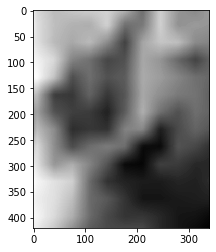

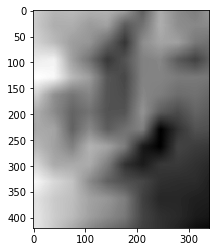

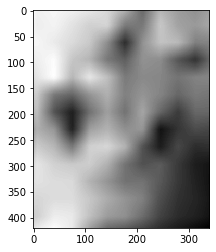

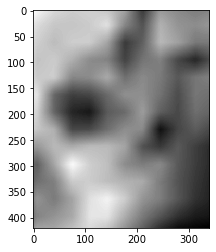

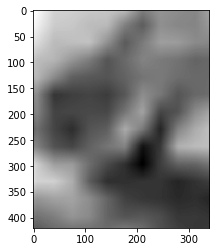

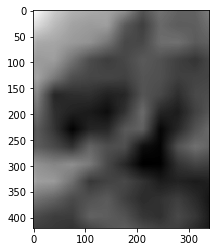

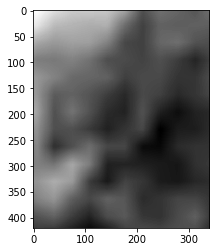

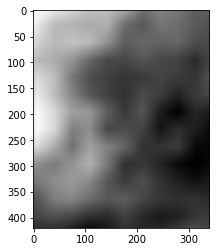

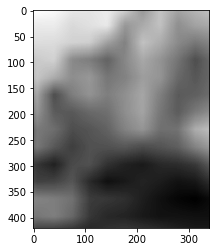

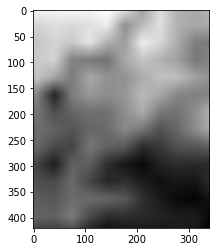

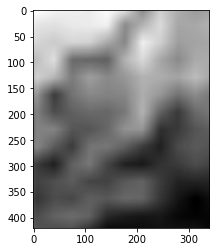

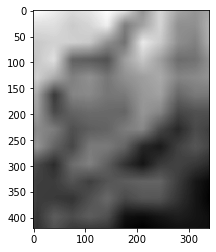

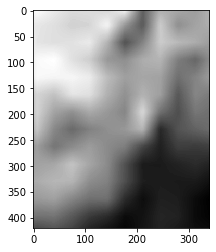

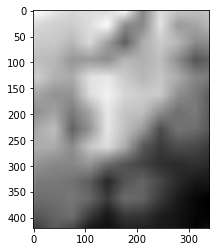

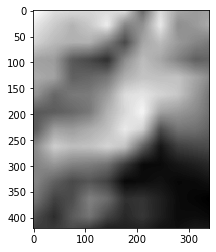

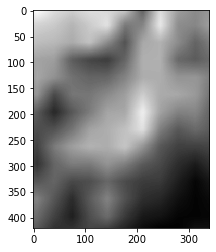

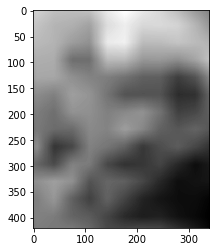

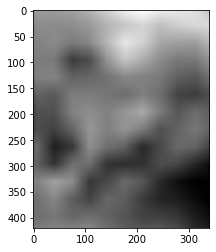

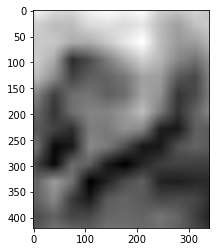

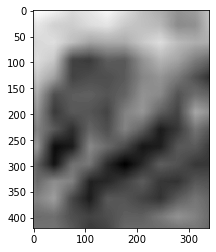

In [10]:
file = np.array(submit)
for i in range(20):
    img = file[i*420:(i+1)*420] 
    img = img.astype(int)
    plt.imshow(img,cmap='gray')
    plt.show()

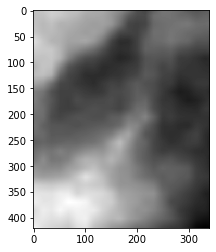

In [9]:
plt.imshow(img,cmap='gray')

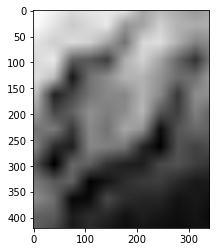

In [15]:
plt.imshow(img,cmap='gray')

In [9]:
submit = []
for i in range(len(cloud_clip)):
    cloud_list = cloud_clip[i]
    
    x = []
    for cloud_id in cloud_list:
        cloud_x = data['cloud'][str(cloud_id)]/255
        x.append(cloud_x)
    x = np.stack(x)

    end_id =  str(cloud_list[-1])
    cloud_met = data_met['HGTs'][end_id]
    x = np.concatenate([x,cloud_met],axis=0)
    x = torch.from_numpy(x).type(torch.float32)
    x = x.unsqueeze(0)  
    x = x.cuda()

    output = cloud2cloud(x)
    output = output.cpu().detach().numpy()[0]
    
    group = []
    for img in output:
        img = cv2.resize(img,(512,640))
        img = img[40:460, 130:470]
        group.append(img)
        #plt.figure(figsize=(8,8))
        #plt.imshow(img,cmap='gray')
        
    group = np.vstack(group)
    group = np.clip(group, 0, 1)
    submit.append(group)
    
submit = np.vstack(submit)